# Cloud Optimized GeoTIFF and Tiling Processing

In this tutorial we will use the *TilingProcessing* class to access [Cloud Optimized GeoTiffs-COG](https://www.cogeo.org/) files, retriving the raster data only for a specific geographic window. 

The public URLs for the COG files are ([check how access it in QGIS](https://www.cogeo.org/qgis-tutorial.html)):

* Landsat ARD (RED): https://s3.eu-central-1.wasabisys.com/eumap/landsat/landsat_ard_20180625_20180912_red_p50
* Landsat ARD (RGB): http://s3.eu-central-1.wasabisys.com/eumap/landsat/landsat_ard_20180625_20180912_p50_RGB.tif
* Sentinel-2 (RGB): http://s3.eu-central-1.wasabisys.com/eumap/sentinel/s2l2a_ard_20180625_20180912_p50_RGB.tif

First, let's import the necessary modules

In [1]:
# To work with local eumap code
import sys
sys.path.append('../../')

from skmap.parallel import TilingProcessing
import rasterio
import numpy as np
from skmap import plotter

import warnings
warnings.filterwarnings('ignore')

The TilingProcessing receives the follow parameters:

* **tiling_system_fn**: Vector file containing the tile geometries. For tiling_system_fn=None the default eumap tiling system will be downloaded from [Zenodo](https://zenodo.org/record/4311598) (eu_tilling system_30km.gpkg),
* **base_raster_fn**: Raster file that will be used to generate the geographic [windows](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html),
* **verbose**: If True will show the progress/debug information.

The *tiling_system_fn* can be a **local file path** or a **remote url** for a COG file.

In [2]:
landsat_red_cog = 'https://s3.eu-central-1.wasabisys.com/eumap/landsat/landsat_ard_20180625_20180912_red_p50'
tiling = TilingProcessing(base_raster_fn=landsat_red_cog, verbose=True, epsg_checking=False)

[15:38:18] Pixel size equal 30.0 in landsat_ard_20180625_20180912_red_p50
[15:38:18] 7042 tiles available in tiling_system_30km.gpkg
[15:38:18] Using EPSG:None


Let's check the total number of tiles.

In [3]:
print(f'Number of tiles: {tiling.num_tiles}')

Number of tiles: 7042


## COG properties

It's possible access all image properties of these COGs files:

In [4]:
landsat_red_cog = 'https://s3.eu-central-1.wasabisys.com/eumap/landsat/landsat_ard_20180625_20180912_red_p50'
landsat_rgb_cog = 'http://s3.eu-central-1.wasabisys.com/eumap/landsat/landsat_ard_20180625_20180912_p50_RGB.tif'
sentinel_rgb_cog = 'http://s3.eu-central-1.wasabisys.com/eumap/sentinel/s2l2a_ard_20180625_20180912_p50_RGB.tif'

We can use rasterio to do it:

In [5]:
def img_properties(ds_path):
    with rasterio.open(ds_path) as ds:
        ds_prop = ds.profile
        for key in ds_prop.keys():
            print(f'{key}: {ds_prop[key]}')

Let's check the result:

In [6]:
img_properties(landsat_red_cog)

driver: GTiff
dtype: uint8
nodata: 0.0
width: 188000
height: 151000
count: 1
crs: PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown_based_on_GRS80_ellipsoid",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
transform: | 30.00, 0.00, 900000.00|
| 0.00,-30.00, 5460010.00|
| 0.00, 0.00, 1.00|
blockxsize: 128
blockysize: 128
tiled: True
compress: deflate
interleave: band


## Tiling processing

It's possible process any of 7,042 tiles using a customized function to do the work. This function will receive the follow parameters:

* **idx**: The tile sequential id (0 to 7041 in our case);
* **tile**: The [GeoSeries](https://geopandas.org/reference.html#geoseries) corresponding to the specified tile;
* **window**: The [rasterio window](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html) object for the tile;
* **func_args**: Aditional parameters to the function (the COG url in our case);

The follow function will be responsable to read all the bands of a COG file, considering the geographic window for the specified tile.

In [7]:
def read_cog(idx, tile, window, cog_url):
    with rasterio.open(cog_url) as ds:
        data = []
        for band in range(1, ds.count+1):
            data.append(ds.read(band, window=window))
        data = np.stack(data, axis=2)
        return data

Let's read the tile 5000 and check the [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) shape.

In [8]:
idx = 5000
tile_data = tiling.process_one(idx, read_cog, landsat_rgb_cog)
print(f'Tile {idx} shape = {tile_data.shape}')

Tile 5000 shape = (1000, 1000, 3)


As this is the actual raster data we can perfom any mathematical operation

In [9]:
print(f'Max value (all bands): {np.max(tile_data)}')
print(f'Median value (all bands): {np.median(tile_data)}')
print(f'Max value (bluen band): {np.max(tile_data[:,:,2])}')
print(f'Median value (blue band): {np.median(tile_data[:,:,2])}')

Max value (all bands): 77
Median value (all bands): 7.0
Max value (bluen band): 63
Median value (blue band): 4.0


...and plot a RGB composition:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


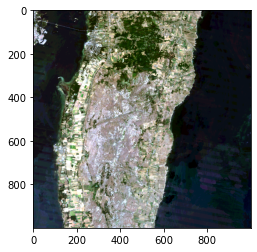

In [10]:
plotter.plot_rgb(tile_data)

We can do the same approach with the Sentinel-2 image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


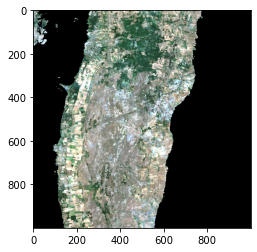

In [11]:
tile_data_s2 = tiling.process_one(idx, read_cog, sentinel_rgb_cog)

# nodata fix to plot correctly the RGB image
tile_data_s2[tile_data_s2 == 32767] = 0
plotter.plot_rgb(tile_data_s2)

## Point query

It's possible to query any coordinate point from EU retriving the pixel values from a COG raster. 

First the coordinate need to be converted to default spatial projection system of EUMAP library ([EPSG:3035](https://epsg.io/3035)):

In [12]:
from pyproj import Transformer

lon, lat = 4.0571, 50.3871

transformer = Transformer.from_crs("epsg:4326", "epsg:3035")
lon_3035, lat_3035 = transformer.transform(lon, lat)

After you need use the [rasterio.sample](https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html) module: 

In [13]:
import rasterio

coords = [ (lon_3035, lat_3035) ]
with rasterio.open(landsat_rgb_cog) as ds:
    print(f'Pixel value for {lon} and {lat}')
    for val in rasterio.sample.sample_gen(ds, coords):
        print(f'-RGB: {val}')

Pixel value for 4.0571 and 50.3871
-RGB: [0 0 0]


### Parallel query

Now it's time to query multiple points in parallel using a list of coordinates:

In [14]:
coords = [
    ( 4.0571, 50.3871),
    ( 11.3609, 61.9628 ),
    ( 17.91110, 47.25202 ),
    ( 10.20801, 46.27658 ),
    ( 16.27374, 40.60558 ),
    ( -3.79936, 38.33536 ),
    ( -1.14809, 52.57290 ),
    ( -8.180883, 53.591171 ),
    ( 20.83392, 42.07786 ),
    ( 16.67624, 51.34765 )
]

It's necessary create a function to do this job

In [15]:
from pyproj import Transformer

def query_point(lon, lat):
    with rasterio.open(landsat_rgb_cog) as ds:
        transformer = Transformer.from_crs("epsg:4326", "epsg:3035")
        lon_3035, lat_3035 = transformer.transform(lon, lat)
        return lon, lat, list(rasterio.sample.sample_gen(ds, [ (lon_3035, lat_3035) ]))[0]

...and pass this function for our the eumap class ThreadGeneratorLazy:

In [16]:
from skmap.parallel import ThreadGeneratorLazy

n_workers = 10

for lon_3035, lat_3035, values in ThreadGeneratorLazy(query_point, iter(coords), n_workers, n_workers):
    print(f'Pixel value for {lon_3035} and {lat_3035}')
    print(f' -RGB: {values}\n')

Pixel value for 11.3609 and 61.9628
 -RGB: [0 0 0]

Pixel value for 17.9111 and 47.25202
 -RGB: [0 0 0]

Pixel value for 4.0571 and 50.3871
 -RGB: [0 0 0]

Pixel value for 10.20801 and 46.27658
 -RGB: [0 0 0]

Pixel value for -1.14809 and 52.5729
 -RGB: [0 0 0]

Pixel value for -8.180883 and 53.591171
 -RGB: [0 0 0]

Pixel value for 16.27374 and 40.60558
 -RGB: [0 0 0]

Pixel value for -3.79936 and 38.33536
 -RGB: [0 0 0]

Pixel value for 16.67624 and 51.34765
 -RGB: [0 0 0]

Pixel value for 20.83392 and 42.07786
 -RGB: [0 0 0]

